11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


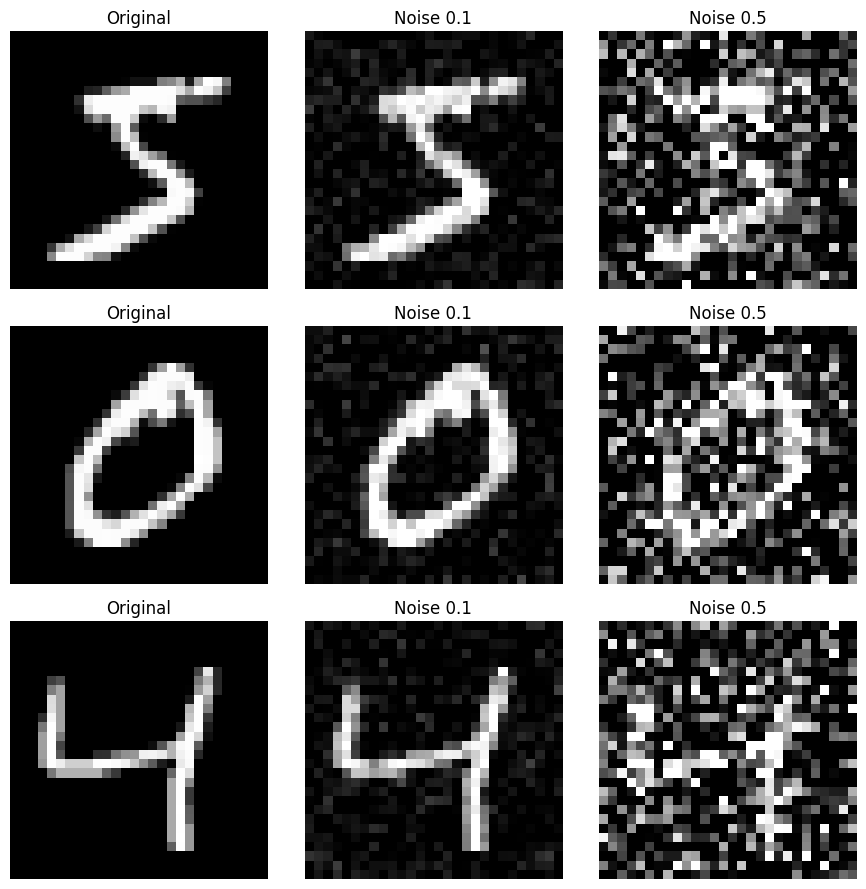

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.
shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train
.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)
#Visualize in a 3 x 3 grid
n = 3 # number of images to show
plt.figure(figsize=(9, 9))
for i in range(n):
  # Original image
  ax = plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
  plt.title("Original")
  plt.axis('off')
  # Low noise image
  ax = plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.1")
  plt.axis('off')
  # High noise image
  ax = plt.subplot(n, 3, i * 3 + 3)
  plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.5")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input

def build_encoder(input_shape=(28, 28, 1)):
  """
  Builds the encoder part of the convolutional autoencoder.
  Parameters:
  input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.
  Returns:
  input_img (Keras Input): Input layer of the model.
  encoded (Keras Tensor): Encoded representation after convolution and pooling.
  """
  input_img = Input(shape=input_shape, name="input")
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
  return input_img, encoded

In [ ]:
from tensorflow.keras.layers import UpSampling2D

def build_decoder(encoded_input):
  """
  Builds the decoder part of the convolutional autoencoder.
  Parameters:
  encoded_input (Keras Tensor): The output from the encoder.
  Returns:
  decoded (Keras Tensor): The reconstructed output after upsampling and
  convolution.
  """
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
  return decoded

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_autoencoder():
  """
  Constructs and compiles the full convolutional autoencoder by connecting encoder and
  decoder.
  Returns:
  autoencoder (Keras Model): Compiled autoencoder model.
  """
  input_img, encoded_output = build_encoder()
  decoded_output = build_decoder(encoded_output)
  autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
  autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
  return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoded (MaxPooling2D)               │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoded (Conv2D)                     │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()
# Train with noisy input and clean target
history = autoencoder.fit(
  x_train_noisy_high, x_train,
  epochs=10,
  batch_size=128,
  shuffle=True,
  validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.2178 - val_loss: 0.1113
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1104 - val_loss: 0.1042
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1044 - val_loss: 0.1014
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1016 - val_loss: 0.0994
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0997 - val_loss: 0.0980
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0984 - val_loss: 0.0976
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0976 - val_loss: 0.0965
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0967 - val_loss: 0.0962
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0963 - val_loss: 0.0954
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0954 - val_loss: 0.0955


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


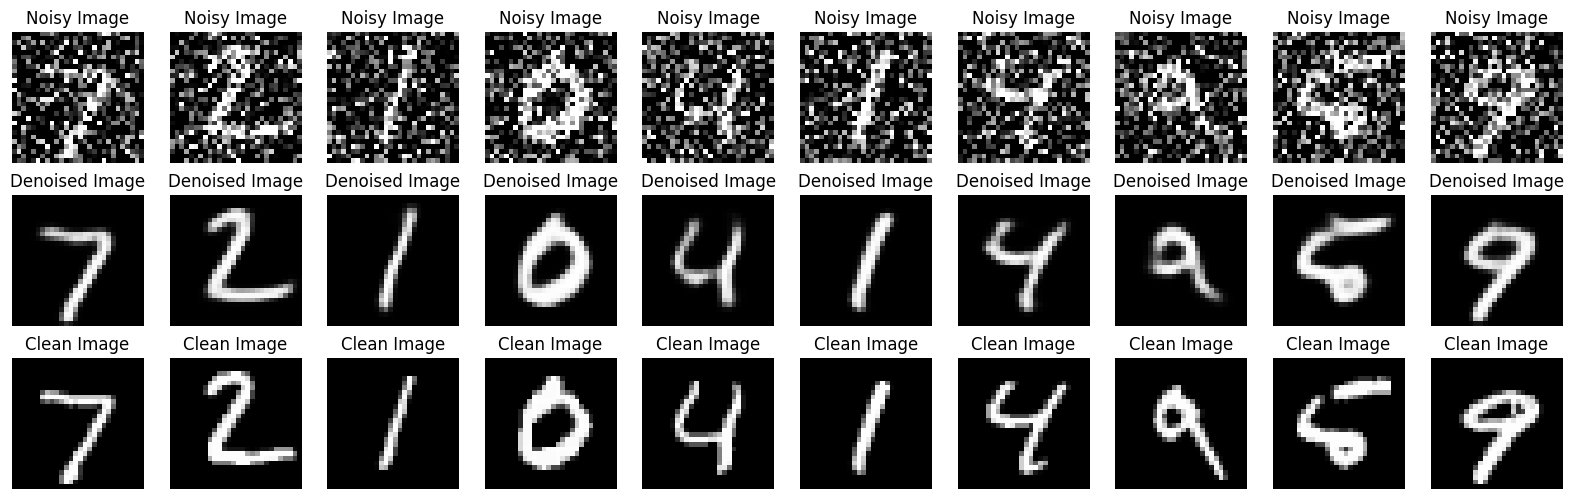

In [ ]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)
# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
  plt.figure(figsize=(20, 6))
  for i in range(n):
    # Plot noisy images
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')
    # Plot denoised images
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised Image")
    plt.axis('off')
    # Plot clean images
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
    plt.title("Clean Image")
    plt.axis('off')
  plt.show()
# Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

In [ ]:
!gdown 1ZF7SbltEK_DH81xIGlwG4LOEg9MbwsBh

Downloading...
From (original): https://drive.google.com/uc?id=1ZF7SbltEK_DH81xIGlwG4LOEg9MbwsBh
From (redirected): https://drive.google.com/uc?id=1ZF7SbltEK_DH81xIGlwG4LOEg9MbwsBh&confirm=t&uuid=2f314160-1d3e-4181-aea7-5054dd8bb267
To: /content/Copy of Copy of devnagari digit.zip
100% 16.6M/16.6M [00:00<00:00, 237MB/s]


In [ ]:
!unzip Copy\ of\ Copy\ of\ devnagari\ digit.zip

Streaming output truncated to the last 5000 lines.
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10299.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10300.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10301.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10302.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10303.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10304.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10306.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10307.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104017.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104018.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104019.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104021.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104023.p

Training set:(17000, 28, 28, 1), Labels:(17000, 10)
Testing set: (3000, 28, 28, 1), Labels:(3000, 10)


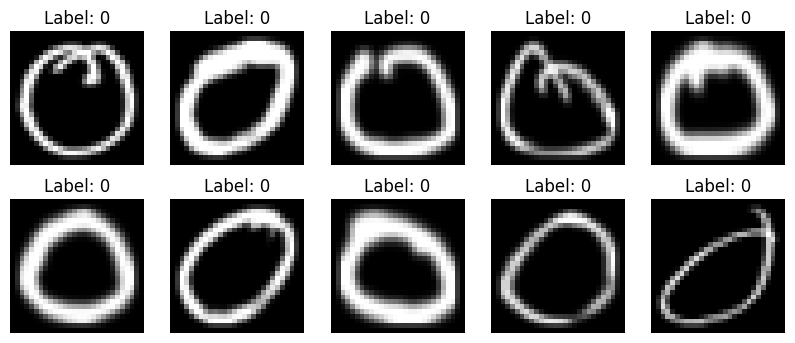

In [ ]:
from pickle import load
train_dir = "/content/DevanagariHandwrittenDigitDataset/Train/"
test_dir = "/content/DevanagariHandwrittenDigitDataset/Test/"

img_height, img_width = 28, 28
num_classes = 10

def load_and_preprocess_image(folder):
  images = []
  labels = []
  class_names = sorted(os.listdir(folder))
  class_map = {name: i for i, name in enumerate(class_names)}
  for class_name in class_names:
    class_path = os.path.join(folder, class_name)
    label = class_map[class_name]
    for img_name in os.listdir(class_path):
      img_path = os.path.join(class_path, img_name)
      img = Image.open(img_path).convert('L')
      img = img.resize((img_height, img_width))
      img = np.array(img) / 255.0

      images.append(img)
      labels.append(label)

  return np.array(images), np.array(labels)

x_train, y_train = load_and_preprocess_image(train_dir)
x_test, y_test = load_and_preprocess_image(test_dir)

x_train = x_train.reshape(-1, img_height, img_width, 1)
x_test = x_test.reshape(-1, img_height, img_width, 1)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"Training set:{x_train.shape}, Labels:{y_train.shape}")
print(f"Testing set: {x_test.shape}, Labels:{y_test.shape}")

plt.figure(figsize=(10,4))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(x_train[i].reshape(img_height, img_width), cmap='gray')
  plt.title(f"Label: {np.argmax(y_train[i])}")
  plt.axis("off")

plt.show()


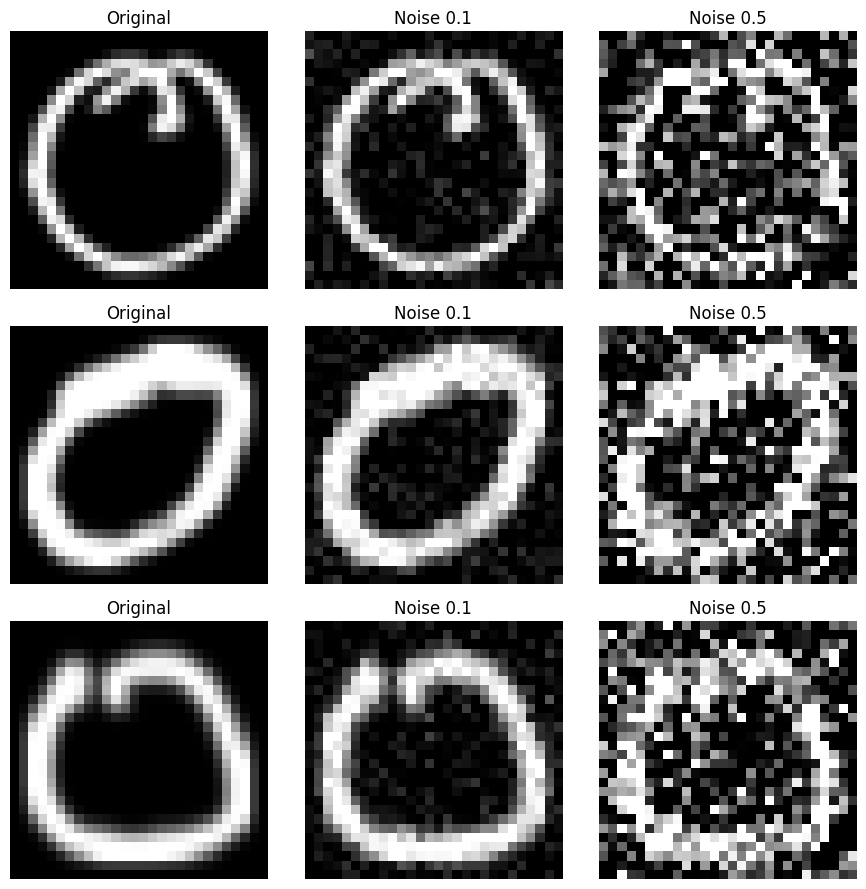

In [ ]:
#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.
shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train
.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)
#Visualize in a 3 x 3 grid
n = 3 # number of images to show
plt.figure(figsize=(9, 9))
for i in range(n):
# Original image
  ax = plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
  plt.title("Original")
  plt.axis('off')
  # Low noise image
  ax = plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.1")
  plt.axis('off')
  # High noise image
  ax = plt.subplot(n, 3, i * 3 + 3)
  plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.5")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def build_encoder(input_shape=(28, 28, 1)):
  """
  Builds the encoder part of the convolutional autoencoder.
  Parameters:
  input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.
  Returns:
  input_img (Keras Input): Input layer of the model.
  encoded (Keras Tensor): Encoded representation after convolution and pooling.
  """
  input_img = Input(shape=input_shape, name="input")
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
  return input_img, encoded

In [ ]:
def build_decoder(encoded_input):
  """
  Builds the decoder part of the convolutional autoencoder.
  Parameters:
  encoded_input (Keras Tensor): The output from the encoder.

  Returns:
  decoded (Keras Tensor): The reconstructed output after upsampling and
  convolution.
  """
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
  return decoded

In [ ]:
def build_autoencoder():
  """
  Constructs and compiles the full convolutional autoencoder by connecting encoder and
  decoder.
  Returns:
  autoencoder (Keras Model): Compiled autoencoder model.
  """
  input_img, encoded_output = build_encoder()
  decoded_output = build_decoder(encoded_output)
  autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
  autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
  return autoencoder

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoded (MaxPooling2D)               │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoded (Conv2D)                     │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()
# Train with noisy input and clean target
history = autoencoder.fit(
  x_train_noisy_high, x_train,
  epochs=10,
  batch_size=128,
  shuffle=True,
  validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 52s 375ms/step - loss: 0.4428 - val_loss: 0.2161
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 380ms/step - loss: 0.2113 - val_loss: 0.2017
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 80s 361ms/step - loss: 0.2004 - val_loss: 0.1956
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 362ms/step - loss: 0.1954 - val_loss: 0.1926
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 356ms/step - loss: 0.1926 - val_loss: 0.1919
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 358ms/step - loss: 0.1904 - val_loss: 0.1888
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 371ms/step - loss: 0.1885 - val_loss: 0.1876
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 80s 359ms/step - loss: 0.1880 - val_loss: 0.1865
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 89s 413ms/step - loss: 0.1865 - val_loss: 0.1858
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 373ms/step - loss: 0.1853 - val_loss: 0.1853


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


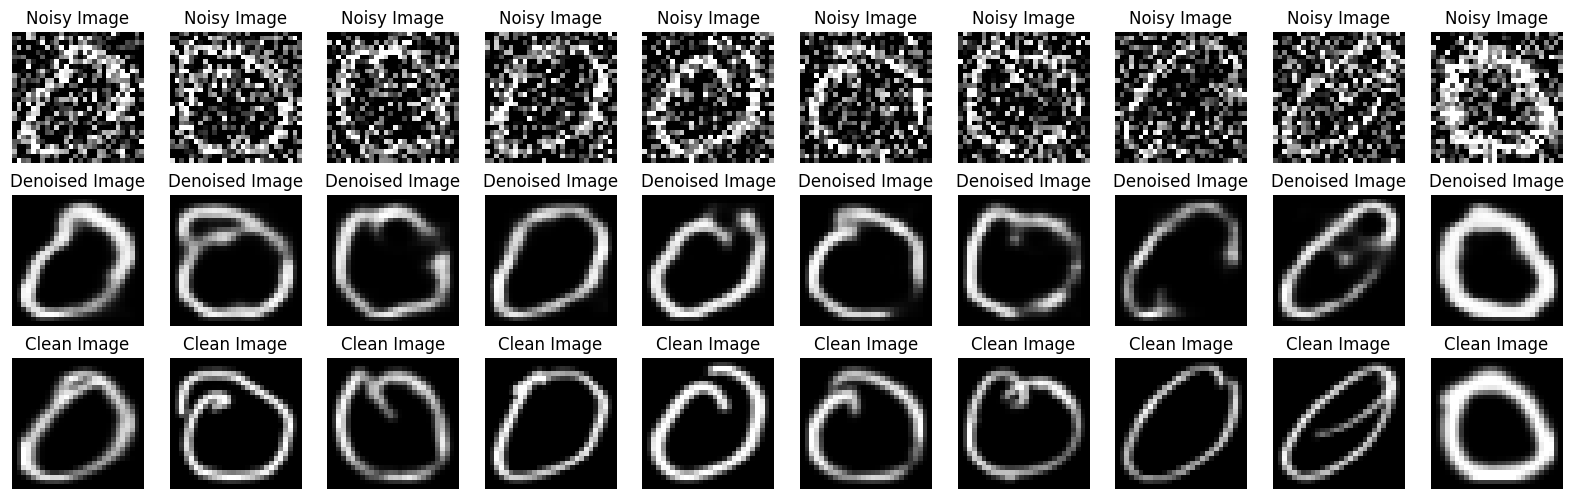

In [ ]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)
# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
  plt.figure(figsize=(20, 6))
  for i in range(n):
    # Plot noisy images
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')
    # Plot denoised images
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised Image")
    plt.axis('off')
    # Plot clean images
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
    plt.title("Clean Image")
    plt.axis('off')
  plt.show()
  # Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)